In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler

In [13]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')

In [20]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [26]:
resultado = one_hot_encoder.fit_transform(df.Fuel_Type.values.reshape(-1, 1))

In [35]:
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [36]:
fuel_type_encoder

,CNG,Diesel,Petrol
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
1431,0.0,0.0,1.0
1432,0.0,0.0,1.0
1433,0.0,0.0,1.0
1434,0.0,0.0,1.0


In [14]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='Weight', ylabel='Price'>

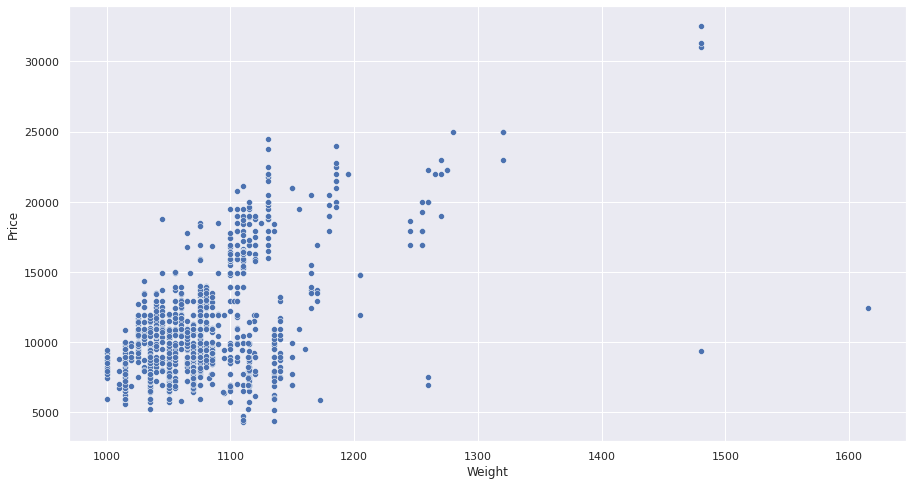

In [15]:
sns.scatterplot(x=df.Weight, y=df.Price)

<AxesSubplot:xlabel='KM', ylabel='Price'>

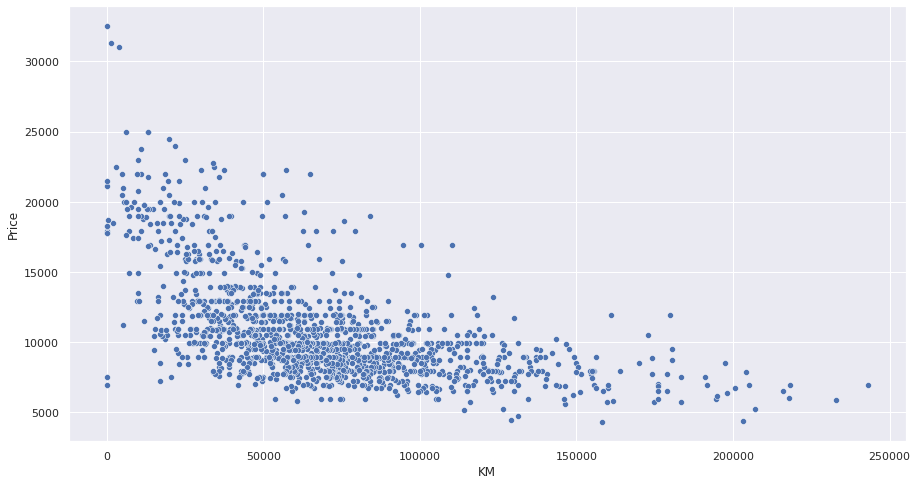

In [16]:
sns.scatterplot(x=df.KM, y=df.Price)

In [6]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float
        Minimum of interval containing the knots.
    maxval: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.
    max: float
        Maximum of the interval containing the knots.
    n_knots: positive integer
        The number of knots to create.
    knots: array or list of floats
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

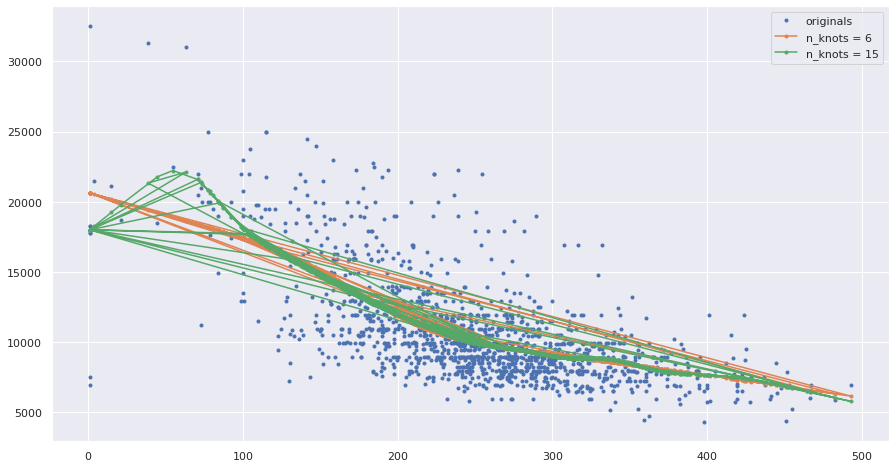

In [17]:
from matplotlib import pyplot as plt
import numpy as np

# make example data
x = np.sqrt(df.KM)
y = df.Price

# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)


plt.plot(x, y, ls='', marker='.', label='originals')
plt.plot(x, y_est_6, marker='.', label='n_knots = 6')
plt.plot(x, y_est_15, marker='.', label='n_knots = 15')
plt.legend(); plt.show()

In [9]:
df.shape

(1436, 37)

In [31]:
#OUTLIERS
Q1 = df.Price.quantile(0.25)
Q3 = df.Price.quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
out = ((df.Price < BI) | (df.Price > BS))
out.sum()

110

In [35]:
100*out.sum()/out.count()

7.66016713091922

In [37]:
#OUTLIERS APLICANDO LOG
price_log = np.log(df.Price)
Q1 = price_log.quantile(0.25)
Q3 = price_log.quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
out = ((price_log < BI) | (price_log > BS))
out.sum()

41

In [38]:
100*out.sum()/out.count()

2.8551532033426184

In [28]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

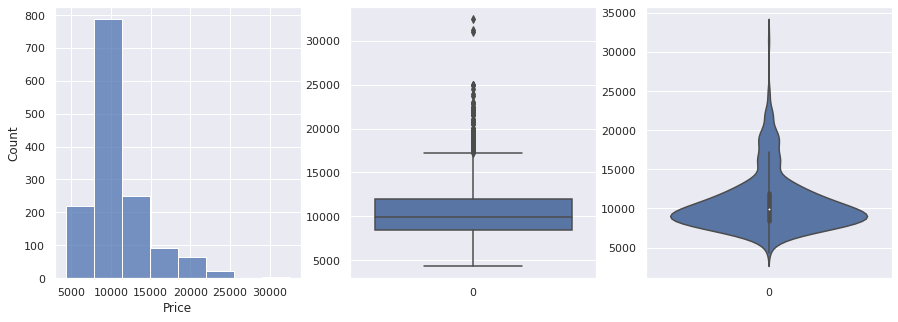

In [29]:
graficar_info_variable(df.Price)

In [34]:
df2 = df.Price > 15000
df2.sum()

168